In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision
from statistics import mean

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [3]:
input_dim = 28*28
hidden_dim = 10
out_dim = 10


class ConvolutionalNetwork(nn.Module):

  def __init__(self, input_dim, out_dim):

    super(ConvolutionalNetwork, self).__init__()
    # Convolutional Neural Network Layer
    self.convolutaional_neural_network_layers = nn.Sequential(
                            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(3,3), padding=1, stride=1), # (N, 1, 28, 28)
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                            nn.Conv2d(in_channels=5, out_channels=5, kernel_size=(3,3), padding=1, stride=1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

    # Linear layer
    self.linear_layers = nn.Sequential(
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=5*7*7, out_features=out_dim),
        )

    #Softmax
    self.soft = nn.Softmax(dim=1)


  # Defining the forward pass
  def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the linear layer
        x = self.linear_layers(x)

        x = self.soft(x)

        return x

In [4]:
model = ConvolutionalNetwork(input_dim, out_dim).to(device)

if device.type != "cpu":
  model = torch.compile(model)
else:
  model = torch.compile(model, mode = "max-autotune-no-cudagraphs", dynamic=True)


In [5]:
loss_function = nn.CrossEntropyLoss()

In [6]:
def accuracy(y_pred, y):

  pred = y_pred.detach().argmax(dim=1)
  corrects = (pred == y)

  accuracy = (corrects.sum()/corrects.size(0)).float()

  return accuracy

def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

  acc_train, acc_test = 0, 0

  with torch.no_grad():

    for x_train, y_train in train_loader:

      x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

      out = model(x_train).squeeze()
      acc_train += accuracy(out, y_train)

    for x_test, y_test in test_loader:

      x_test, y_test = x_test.to(device), y_test.to(device)

      out = model(x_test).squeeze()
      acc_test += accuracy(out, y_test)

    acc_train, acc_test = acc_train / len(train_loader), acc_test / len(test_loader)

  return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100

def train(model, x, y):

  out = model(x)
  loss = loss_function(out.squeeze(), y)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()
  return float(loss)

if device.type != "cpu":
  accuracy = torch.compile(accuracy)
  train = torch.compile(train)
else:
  accuracy = torch.compile(accuracy, mode = "max-autotune-no-cudagraphs", dynamic=True)
  train = torch.compile(train, mode = "max-autotune-no-cudagraphs", dynamic=True)


In [7]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
    self.patience = patience       # Number of epochs to wait for improvement
    self.delta = delta             # Minimum change in monitored metric to qualify as improvement
    self.verbose = verbose         # If True, print a message when validation metric improves
    self.path = path               # Path to save the model checkpoint
    self.counter = 0               # Counter to track epochs without improvement
    self.best_score = None         # Best validation metric achieved so far
    self.early_stop = False        # Flag to indicate whether to stop training

  def __call__(self, val_metric, model):
    if self.best_score is None:
      self.best_score = val_metric
      self.save_checkpoint(model)
    elif val_metric > self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True
    else:
      self.best_score = val_metric
      self.save_checkpoint(model)
      self.counter = 0

  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path)


In [8]:
! mkdir /content/.checkpoints

In [9]:
n_train = 2004
n_test = 500
ratio = 12

batch_size_train = 144
batch_size_test = n_test

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[:n_test], dataset_test.targets[:n_test]

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 18224042.63it/s]


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1881544.15it/s]


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1400642.04it/s]


Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6449061.87it/s]

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



In [10]:
train_losses = []
train_accuracies = []
test_accuracies = []


for i in range (1,ratio):
  for j in range (10):
    ## TRAIN SET

    n_train_loop = int(n_train * i / ratio)

    batch_size_train_loop = int(batch_size_train * i / ratio)

    dataset_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=transform)

    dataset_train.data, dataset_train.targets = dataset_train.data[:n_train_loop], dataset_train.targets[:n_train_loop]

    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size_train_loop,
                                                shuffle = True,  drop_last = True)
    EPOCHS = 101



    learning_rate = 0.1
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    early_stopping = EarlyStopping(patience=4, verbose=True, path='/content/.checkpoints/model_checkpoint.pt')
    train_acc_avarage = []
    test_acc_avarage = []

    for epoch in range(1,EPOCHS):

      train_loss = 0

      ## TRAIN STEP

      for x_train, y_train in train_loader:

        x_train, y_train = x_train.to(device), y_train.to(device)


        loss = train(model, x_train, y_train)

        train_loss += loss

      train_loss /= len(train_loader)                    # we divide by the number of batches
      train_losses.append(train_loss)

      ## TEST STEP

      if epoch % 100 == 0:

        train_acc, test_acc = evaluate(model, train_loader, test_loader)

        train_acc_avarage.append(train_acc)
        test_acc_avarage.append(test_acc)

        print("Epoch:", epoch, "Loss:", float(train_loss))

      if early_stopping.early_stop:
        train_acc, test_acc = evaluate(model, train_loader, test_loader)

        train_acc_a
        varage.append(train_acc)
        test_acc_avarage.append(test_acc)
        print("Early stopping triggered.")
        break

  train_acc_av = mean(train_acc_avarage)
  test_acc_av = mean(test_acc_avarage)
  train_accuracies.append(train_acc_av)
  test_accuracies.append(test_acc_av)


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
W0528 08:53:11.784000 133430971260928 torch/_logging/_internal.py:1013] [2/0] Profiler function <class 'torch.autograd.profiler.record_function'> will be ignored


Epoch: 100 Loss: 1.5602396176411555
Epoch: 100 Loss: 1.5690260116870587
Epoch: 100 Loss: 1.483287710409898


W0528 08:54:25.118000 133430971260928 torch/_dynamo/convert_frame.py:357] torch._dynamo hit config.cache_size_limit (8)
W0528 08:54:25.118000 133430971260928 torch/_dynamo/convert_frame.py:357]    function: 'step' (/usr/local/lib/python3.10/dist-packages/torch/optim/sgd.py:60)
W0528 08:54:25.118000 133430971260928 torch/_dynamo/convert_frame.py:357]    last reason: len(L['self'].state) == 6                                   
W0528 08:54:25.118000 133430971260928 torch/_dynamo/convert_frame.py:357] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0528 08:54:25.118000 133430971260928 torch/_dynamo/convert_frame.py:357] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.


Epoch: 100 Loss: 1.4679612196408784
Epoch: 100 Loss: 1.4799743799062877
Epoch: 100 Loss: 1.4678118870808528
Epoch: 100 Loss: 1.4677881002426147
Epoch: 100 Loss: 1.4675741103979258
Epoch: 100 Loss: 1.4619908516223614
Epoch: 100 Loss: 1.4611551211430476
Epoch: 100 Loss: 1.4865451592665453
Epoch: 100 Loss: 1.468832327769353
Epoch: 100 Loss: 1.4676568599847646
Epoch: 100 Loss: 1.4677387751065767
Epoch: 100 Loss: 1.4751051114155695
Epoch: 100 Loss: 1.4674045856182392
Epoch: 100 Loss: 1.4730939590013945
Epoch: 100 Loss: 1.4707111578721266
Epoch: 100 Loss: 1.4759497092320368
Epoch: 100 Loss: 1.4684306841630201
Epoch: 100 Loss: 1.4757979924862201
Epoch: 100 Loss: 1.4757853471315825
Epoch: 100 Loss: 1.4760256088696992
Epoch: 100 Loss: 1.4725936192732592
Epoch: 100 Loss: 1.4711977243423462
Epoch: 100 Loss: 1.468932738670936
Epoch: 100 Loss: 1.4679042742802546
Epoch: 100 Loss: 1.4660148528906016
Epoch: 100 Loss: 1.4655321744772105
Epoch: 100 Loss: 1.464212912779588
Epoch: 100 Loss: 1.473539242377

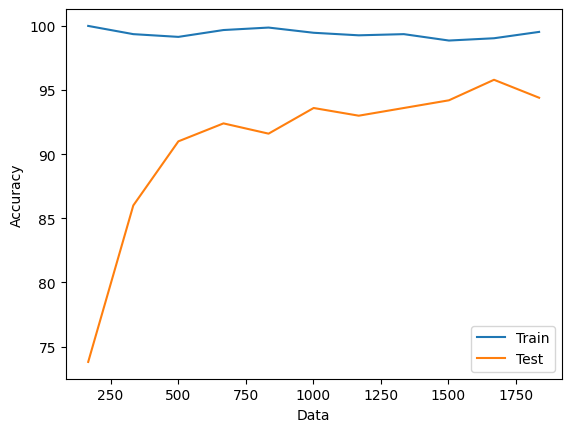

In [11]:
data = [n_train * i/ratio for i in range(1, ratio)]

plt.plot(data, train_accuracies, label = "Train")
plt.plot(data, test_accuracies, label = "Test")

plt.xlabel("Data")
plt.ylabel("Accuracy")


plt.legend()

plt.show()

In [1]:
train_accuracies

NameError: name 'train_accuracies' is not defined

In [2]:
test_accuracies

NameError: name 'test_accuracies' is not defined